<a href="https://colab.research.google.com/github/saktiworkstation/road-to-ai-developer/blob/main/22_11_4677_Sakti_Pengantar_MLlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()
findspark.find()

'/usr/local/lib/python3.10/dist-packages/pyspark'

In [ ]:
# spark.stop()
# creating Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("RDD")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark
sc = spark.sparkContext

In [ ]:
df = spark.read.csv("/content/diabetes.csv", header=True, inferSchema=True)
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [ ]:
data = df.select('Glucose')

In [ ]:
data.show()

+-------+
|Glucose|
+-------+
|    148|
|     85|
|    183|
|     89|
|    137|
|    116|
|     78|
|    115|
|    197|
|    125|
|    110|
|    168|
|    139|
|    189|
|    166|
|    100|
|    118|
|    107|
|    103|
|    115|
+-------+
only showing top 20 rows



## TF-IDF

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

sentenceData = spark.createDataFrame([
    (0.0, "Hi I heard about Spark"),
    (0.0, "I wish Java could use case classes"),
    (1.0, "Logistic regression models are neat")
], ["label", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(20,[6,8,13,16],[...|
|  0.0|(20,[0,2,7,13,15,...|
|  1.0|(20,[3,4,6,11,19]...|
+-----+--------------------+



## Word2Vec

In [ ]:
from pyspark.ml.feature import Word2Vec

# Input data: Each row is a bag of words from a sentence or document.
documentDF = spark.createDataFrame([
    ("Hi I heard about Spark".split(" "), ),
    ("I wish Java could use case classes".split(" "), ),
    ("Logistic regression models are neat".split(" "), )
], ["text"])

# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="text", outputCol="result")
model = word2Vec.fit(documentDF)

result = model.transform(documentDF)
for row in result.collect():
    text, vector = row
    print("Text: [%s] => \nVector: %s\n" % (", ".join(text), str(vector)))

Text: [Hi, I, heard, about, Spark] => 
Vector: [0.07733200639486314,0.03594674994237721,-0.06932158377021551]

Text: [I, wish, Java, could, use, case, classes] => 
Vector: [0.0350749705518995,0.009835560406957353,-0.0435352704620787]

Text: [Logistic, regression, models, are, neat] => 
Vector: [-0.03868681192398071,0.007259034365415574,0.05351490639150143]



## Countvectorizer

In [ ]:
from pyspark.ml.feature import CountVectorizer

# Input data: Each row is a bag of words with a ID.
df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="features", vocabSize=3, minDF=2.0)

model = cv.fit(df)

result = model.transform(df)
result.show(truncate=False)

+---+---------------+-------------------------+
|id |words          |features                 |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+



## PIPELINE

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
print (prediction.collect())
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row
    print("(%d, %s) --> prob=%s, prediction=%f" % (rid, text, str(prob), prediction))

[Row(id=4, text='spark i j k', words=['spark', 'i', 'j', 'k'], features=SparseVector(262144, {19036: 1.0, 68693: 1.0, 173558: 1.0, 213660: 1.0}), rawPrediction=DenseVector([0.5288, -0.5288]), probability=DenseVector([0.6292, 0.3708]), prediction=0.0), Row(id=5, text='l m n', words=['l', 'm', 'n'], features=SparseVector(262144, {1303: 1.0, 52644: 1.0, 248090: 1.0}), rawPrediction=DenseVector([4.1691, -4.1691]), probability=DenseVector([0.9848, 0.0152]), prediction=0.0), Row(id=6, text='spark hadoop spark', words=['spark', 'hadoop', 'spark'], features=SparseVector(262144, {173558: 2.0, 198017: 1.0}), rawPrediction=DenseVector([-1.865, 1.865]), probability=DenseVector([0.1341, 0.8659]), prediction=1.0), Row(id=7, text='apache hadoop', words=['apache', 'hadoop'], features=SparseVector(262144, {68303: 1.0, 198017: 1.0}), rawPrediction=DenseVector([5.4156, -5.4156]), probability=DenseVector([0.9956, 0.0044]), prediction=0.0)]
(4, spark i j k) --> prob=[0.6292098489668484,0.3707901510331516],

# Penugasan

In [ ]:
!pip install pyspark
!wget https://repo1.maven.org/maven2/com/crealytics/spark-excel_2.12/0.13.5/spark-excel_2.12-0.13.5.jar

--2024-11-28 02:42:07--  https://repo1.maven.org/maven2/com/crealytics/spark-excel_2.12/0.13.5/spark-excel_2.12-0.13.5.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6131669 (5.8M) [application/java-archive]
Saving to: ‘spark-excel_2.12-0.13.5.jar’

spark-excel_2.12-0. 100%[===================>]   5.85M  5.96MB/s    in 1.0s    

2024-11-28 02:42:09 (5.96 MB/s) - ‘spark-excel_2.12-0.13.5.jar’ saved [6131669/6131669]



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
spark = SparkSession.builder.appName("Prediksi Harga Rumah Jaksel").getOrCreate()

In [ ]:
file_path = "/content/HARGA RUMAH JAKSEL.xlsx"
pandas_df = pd.read_excel(file_path, header=1)
df = spark.createDataFrame(pandas_df)

In [ ]:
df.describe()

DataFrame[summary: string, HARGA: string, LT: string, LB: string, JKT: string, JKM: string]

In [ ]:
print("Menampilkan 5 baris pertama dari dataset:")
df.show(5)

Menampilkan 5 baris pertama dari dataset:
+-----------+----+---+---+---+
|      HARGA|  LT| LB|JKT|JKM|
+-----------+----+---+---+---+
|28000000000|1100|700|  5|  6|
|19000000000| 824|800|  4|  4|
| 4700000000| 500|400|  4|  3|
| 4900000000| 251|300|  5|  4|
|28000000000|1340|575|  4|  5|
+-----------+----+---+---+---+
only showing top 5 rows



In [ ]:
print("Memeriksa nilai null pada dataset:")
df.select([when(col(c).isNull(), c).alias(c) for c in df.columns]).show()

Memeriksa nilai null pada dataset:
+-----+----+----+----+----+
|HARGA|  LT|  LB| JKT| JKM|
+-----+----+----+----+----+
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
| NULL|NULL|NULL|NULL|NULL|
+-----+----+----+----+----+
only showing top 20 rows



In [ ]:
df = df.dropna()

In [ ]:
df_pd = df.toPandas()

Visualisasi sebaran harga rumah berdasarkan beberapa fitur:


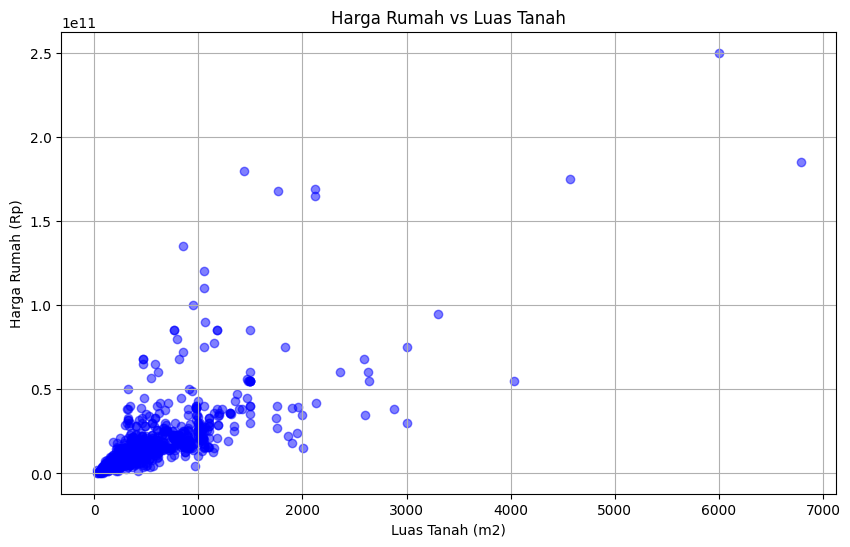

In [ ]:
print("Visualisasi sebaran harga rumah berdasarkan beberapa fitur:")
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['LT'], df_pd['HARGA'], alpha=0.5, color='blue')
plt.xlabel('Luas Tanah (m2)')
plt.ylabel('Harga Rumah (Rp)')
plt.title('Harga Rumah vs Luas Tanah')
plt.grid(True)
plt.show()

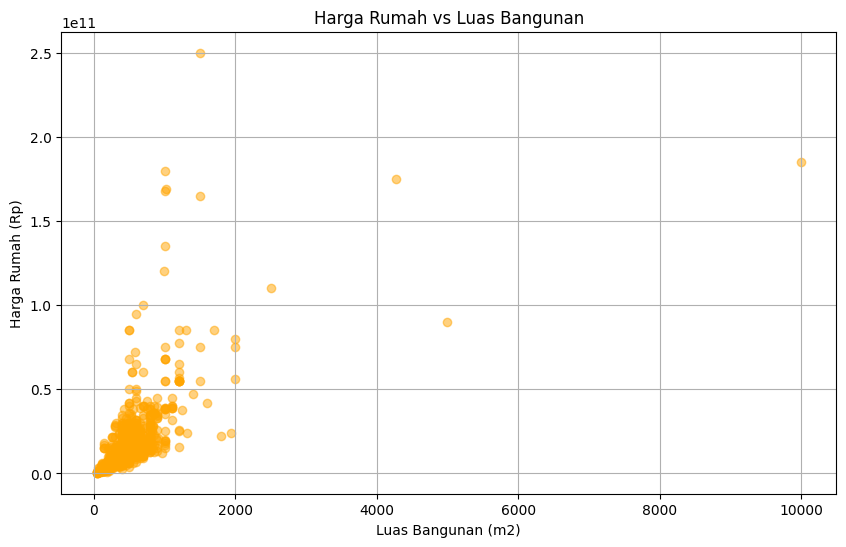

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['LB'], df_pd['HARGA'], alpha=0.5, color='orange')
plt.xlabel('Luas Bangunan (m2)')
plt.ylabel('Harga Rumah (Rp)')
plt.title('Harga Rumah vs Luas Bangunan')
plt.grid(True)
plt.show()

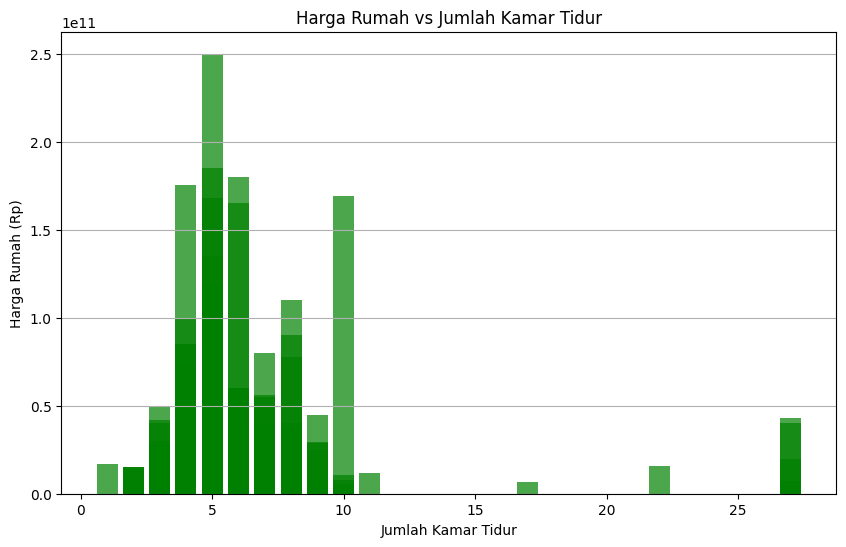

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(df_pd['JKT'], df_pd['HARGA'], alpha=0.7, color='green')
plt.xlabel('Jumlah Kamar Tidur')
plt.ylabel('Harga Rumah (Rp)')
plt.title('Harga Rumah vs Jumlah Kamar Tidur')
plt.grid(True, axis='y')
plt.show()

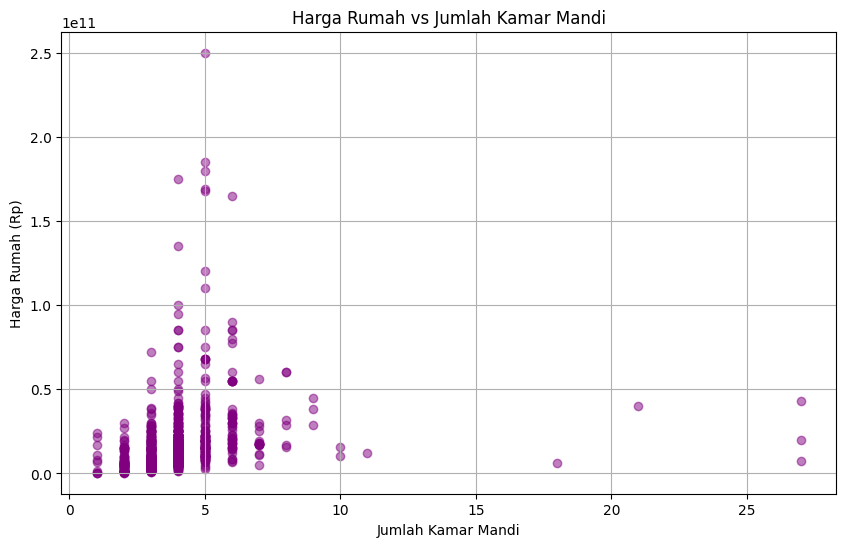

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_pd['JKM'], df_pd['HARGA'], alpha=0.5, color='purple')
plt.xlabel('Jumlah Kamar Mandi')
plt.ylabel('Harga Rumah (Rp)')
plt.title('Harga Rumah vs Jumlah Kamar Mandi')
plt.grid(True)
plt.show()

In [ ]:
# Menggunakan MLlib untuk Prediksi Harga Rumah
# Fitur yang digunakan adalah LuasTanah, LuasBangunan, JumlahKamarTidur, dan JumlahKamarMandi
fitur = ["LT", "LB", "JKT", "JKM"]
assembler = VectorAssembler(inputCols=fitur, outputCol="fitur")
df = assembler.transform(df)

In [ ]:
# Split Data (80% untuk Training, 20% untuk Testing)
training_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Membangun Model Linear Regression
lr = LinearRegression(featuresCol="fitur", labelCol="HARGA")
model = lr.fit(training_data)

In [ ]:
# Prediksi
prediksi = model.transform(test_data)
prediksi.select("Harga", "prediction").show(5)

+----------+--------------------+
|     Harga|          prediction|
+----------+--------------------+
| 850000000|1.4937153140634072E9|
|1930000000| 3.558224229950858E9|
|2790000000| 6.322876471737162E9|
|3400000000|3.5247293341171646E9|
|3790000000| 7.503748910762912E9|
+----------+--------------------+
only showing top 5 rows



In [ ]:
# Evaluasi Model
evaluator = RegressionEvaluator(labelCol="HARGA", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediksi)
print(f"Root Mean Squared Error (RMSE) dari model: {rmse}")

Root Mean Squared Error (RMSE) dari model: 13982791133.301668


Visualisasi hasil prediksi terhadap data test:


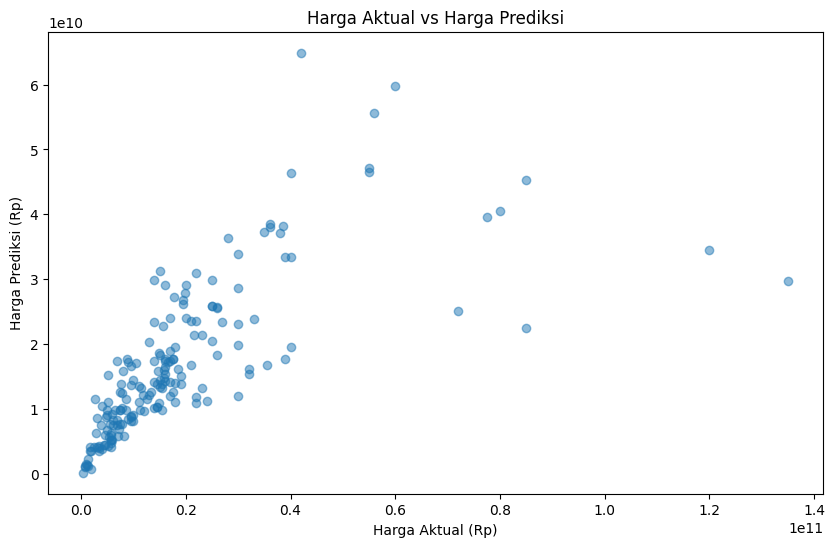

In [ ]:
# Visualisasi Prediksi
print("Visualisasi hasil prediksi terhadap data test:")
prediksi_pd = prediksi.select("Harga", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(prediksi_pd['Harga'], prediksi_pd['prediction'], alpha=0.5)
plt.xlabel('Harga Aktual (Rp)')
plt.ylabel('Harga Prediksi (Rp)')
plt.title('Harga Aktual vs Harga Prediksi')
plt.show()

In [ ]:
# Menampilkan koefisien regresi
print("Koefisien model regresi:")
for fitur, koef in zip(fitur, model.coefficients):
    print(f"{fitur}: {koef}")

print(f"Intercept: {model.intercept}")

Koefisien model regresi:
LT: 22054270.309382364
LB: 10807892.090773214
JKT: 92407695.21018693
JKM: 389609853.04089105
Intercept: -1794917851.3982017


# Coba lagi

In [ ]:
# Fitur yang akan digunakan
fitur = ["LT", "LB", "JKT", "JKM"]
assembler = VectorAssembler(inputCols=fitur, outputCol="fitur")

In [ ]:
# VectorAssembler dengan outputCol yang berbeda
assembler = VectorAssembler(inputCols=fitur, outputCol="fitur_vector")

In [ ]:
# Pipeline
pipeline = Pipeline(stages=[assembler, lr])

In [ ]:
# Melatih model menggunakan pipeline
model = pipeline.fit(training_data)

In [ ]:
# Prediksi pada data uji
prediksi = model.transform(test_data)

In [ ]:
# Tampilkan beberapa hasil prediksi
prediksi.select("HARGA", "prediction").show(5)

+----------+--------------------+
|     HARGA|          prediction|
+----------+--------------------+
| 850000000|1.4937153140634072E9|
|1930000000| 3.558224229950858E9|
|2790000000| 6.322876471737162E9|
|3400000000|3.5247293341171646E9|
|3790000000| 7.503748910762912E9|
+----------+--------------------+
only showing top 5 rows



In [ ]:
# Evaluasi model
evaluator = RegressionEvaluator(labelCol="HARGA", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediksi)
print(f"Root Mean Squared Error (RMSE) dari model: {rmse}")

Root Mean Squared Error (RMSE) dari model: 13982791133.301668
